# DDoS Detection on CSE-CIC-IDS2018 AWS Dataset

This project aims to create a DDoS Detection Classifier trained on labelled network traffic data.

We start by importing a few libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.utils import class_weight

RANDOM_STATE_SEED = 12

In [2]:
# read the data
df_dataset = pd.read_csv(r"../kaggel/input/solarmainframe/ids-intrusion-csv/versions/1/02-14-2018.csv")

In [3]:
# display data
df_dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [4]:
selected_columns = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']
df_dataset = df_dataset[selected_columns]
print(df_dataset.head())

   Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts   Label
0         0         0      112641719             3             0  Benign
1         0         0      112641466             3             0  Benign
2         0         0      112638623             3             0  Benign
3        22         6        6453966            15            10  Benign
4        22         6        8804066            14            11  Benign


In [5]:
# feature information
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Dst Port       1048575 non-null  int64 
 1   Protocol       1048575 non-null  int64 
 2   Flow Duration  1048575 non-null  int64 
 3   Tot Fwd Pkts   1048575 non-null  int64 
 4   Tot Bwd Pkts   1048575 non-null  int64 
 5   Label          1048575 non-null  object
dtypes: int64(5), object(1)
memory usage: 48.0+ MB


In [6]:
# replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\MY PC\AppData\Local\Temp\ipykernel_2864\4071566764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)


In [7]:
df_dataset.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.876262e+03,8.107557e+00,6.255555e+06,6.206622e+00,7.211191e+00
std,1.444344e+04,4.460625e+00,1.260291e+09,4.447851e+01,1.048682e+02
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00
50%,5.300000e+01,6.000000e+00,1.023000e+03,2.000000e+00,1.000000e+00
75%,4.430000e+02,6.000000e+00,4.066690e+05,7.000000e+00,6.000000e+00
max,6.553300e+04,1.700000e+01,1.200000e+08,5.115000e+03,9.198000e+03


In [8]:
# drop missing values
df_dataset.dropna(inplace=True)

C:\Users\MY PC\AppData\Local\Temp\ipykernel_2864\657638106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset.dropna(inplace=True)


In [9]:
df_dataset

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
0,0,0,112641719,3,0,Benign
1,0,0,112641466,3,0,Benign
2,0,0,112638623,3,0,Benign
3,22,6,6453966,15,10,Benign
4,22,6,8804066,14,11,Benign
...,...,...,...,...,...,...
1048570,80,6,10156986,5,5,Benign
1048571,80,6,117,2,0,Benign
1048572,80,6,5095331,3,1,Benign
1048573,80,6,5235511,3,1,Benign


In [10]:
df_dataset["Label"].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [11]:
df = df_dataset

We will now try to visualize the target feature's class distribution.

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='FTP-BruteForce', 
           y=df["Label"].value_counts().values[1:2],
           x=['FTP-BruteForce'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',),
    go.Bar(name='SSH-Bruteforce', 
           y=df["Label"].value_counts().values[2:],
           x=['SSH-Bruteforce'],
           text = df["Label"].value_counts()[2:],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

As expected, most of the traffic is benign.

Since our goal is binary classification ("attack" vs "not attack"), we can group FTP and SSH brute force attacks under one name instead of keeping them separate. Let's name them "Malicious".

In [13]:
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malicious", inplace=True)

C:\Users\MY PC\AppData\Local\Temp\ipykernel_2864\2240561587.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_dataset["Label"].value_counts()

Benign       667626
Malicious    380949
Name: Label, dtype: int64

In [15]:
fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='Malicious', 
           y=df["Label"].value_counts().values[1:2],
           x=['Malicious'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

To prevent our classification model from being biased, we should make sure that the class distribution is even (i.e. 50% benign and 50% malicious).

Since there are 380493 instances of Malicious and 663808 instances of Benign, we can take 380493 instances of both Malicious and Benign to train our model with an even class distribution.

In [16]:
df1 = df[df["Label"] == "Benign"][:380943]
df2 = df[df["Label"] == "Malicious"][:380943]
df_equal = pd.concat([ df1,df2], axis =0)

We now encode our class labels to integer values for the model to use.

In [17]:
df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malicious", value=1, inplace=True)

We split the data into training and testing sets.

In [18]:
train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [19]:
# display columns
train.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'Label'],
      dtype='object')

In [20]:
# feature info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 676152 to 92077
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Dst Port       533320 non-null  int64
 1   Protocol       533320 non-null  int64
 2   Flow Duration  533320 non-null  int64
 3   Tot Fwd Pkts   533320 non-null  int64
 4   Tot Bwd Pkts   533320 non-null  int64
 5   Label          533320 non-null  int64
dtypes: int64(6)
memory usage: 28.5 MB


All of our data except the 'Timestamp' column is numerical. These numerical columns contain different ranges of values, which can confuse our model.
Thus, we must normalize our data.

In [21]:
min_max_scaler = MinMaxScaler().fit(train[selected_columns])
train[selected_columns] = min_max_scaler.transform(train[selected_columns])

In [22]:
train

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
676152,0.804508,0.352941,0.999869,0.000202,0.000000,0.0
429159,0.583135,0.352941,0.999869,0.000202,0.000000,0.0
635436,0.000809,1.000000,0.999869,0.000000,0.000110,0.0
757967,0.000809,1.000000,0.999869,0.000000,0.000110,0.0
362510,0.000320,0.352941,0.999869,0.000000,0.000110,1.0
...,...,...,...,...,...,...
183720,0.000336,0.352941,0.999870,0.004251,0.002422,1.0
32083,0.000320,0.352941,0.999869,0.000000,0.000110,1.0
636315,0.006760,0.352941,1.000000,0.001215,0.001101,0.0
380638,0.000336,0.352941,0.999869,0.000000,0.000110,1.0


In [23]:
train.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
count,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000
mean,0.056635,0.446630,0.999872,0.001047,0.000748,0.500051
std,0.192522,0.234226,0.001879,0.006917,0.009393,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000320,0.352941,0.999869,0.000000,0.000110,0.000000
50%,0.000336,0.352941,0.999869,0.000000,0.000110,1.000000
75%,0.002106,0.352941,0.999870,0.001417,0.000771,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 676152 to 92077
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Dst Port       533320 non-null  float64
 1   Protocol       533320 non-null  float64
 2   Flow Duration  533320 non-null  float64
 3   Tot Fwd Pkts   533320 non-null  float64
 4   Tot Bwd Pkts   533320 non-null  float64
 5   Label          533320 non-null  float64
dtypes: float64(6)
memory usage: 28.5 MB


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533320 entries, 676152 to 92077
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Dst Port       533320 non-null  float64
 1   Protocol       533320 non-null  float64
 2   Flow Duration  533320 non-null  float64
 3   Tot Fwd Pkts   533320 non-null  float64
 4   Tot Bwd Pkts   533320 non-null  float64
 5   Label          533320 non-null  float64
dtypes: float64(6)
memory usage: 28.5 MB


In [26]:
test[selected_columns] = min_max_scaler.transform(test[selected_columns])

In [27]:
test[selected_columns]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
15923,0.000320,0.352941,0.999869,0.000000,0.000110,1.0
252005,0.000336,0.352941,0.999870,0.004251,0.002422,1.0
386353,0.001221,0.352941,0.999869,0.000405,0.000440,0.0
309061,0.000336,0.352941,0.999869,0.000000,0.000110,1.0
497976,0.006791,0.352941,0.999871,0.001012,0.000550,0.0
...,...,...,...,...,...,...
581324,0.000809,1.000000,0.999869,0.000000,0.000110,0.0
663056,0.775926,0.352941,0.999869,0.000405,0.000110,0.0
92705,0.000320,0.352941,0.999869,0.000000,0.000110,1.0
381008,0.000320,0.352941,0.999869,0.000000,0.000110,1.0


In [28]:
print("Full dataset:\n")
print("Benign: " + str(df_equal["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_equal["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 380943
Malicious: 380943
---------------
Training set:

Benign: 266633
Malicious: 266687
---------------
Test set:

Benign: 114310
Malicious: 114256


In [29]:
y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
#y_train = np.array(train.pop("Timestamp"))
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(533320, 5)
(533320,)


In [30]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
#y_test = np.array(test.pop("Timestamp"))
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(228566, 5)
(228566,)


In [31]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    #max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [32]:
clf = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [33]:
clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [50, 75, 100, 125, 150]}, verbose=1)

In [34]:
print("Accuracy score on Validation set: \n")
print(clf.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(clf.best_params_)
print("---------------")
print(clf.best_estimator_)

Accuracy score on Validation set: 

0.9999924998124954
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 50}
---------------
RandomForestClassifier(n_estimators=50)


In [35]:
model = clf.best_estimator_

In [36]:
model

RandomForestClassifier(n_estimators=50)

In [37]:
predictions = model.predict(X_test)

In [38]:
print(accuracy_score(y_test, predictions))

0.9999868746882739


<Axes: >

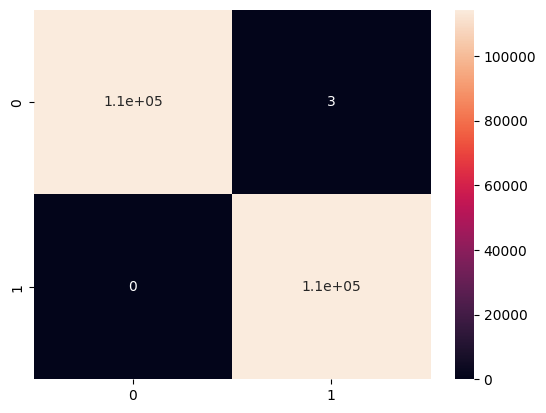

In [39]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

Let us also try making a Neural Network model using Keras.

In [46]:
# Xuất model RandomForest
import pickle

# Assuming you have already trained a model called 'model'
# For example: model = RandomForestClassifier().fit(X_train, y_train)

# Save the model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully as 'model.pkl'")

# To load the model later
# with open('model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

Model saved successfully as 'model.pkl'


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [41]:
# ANN
neuralNetModel = keras.Sequential([
    layers.InputLayer(input_shape=(5,)),
       
    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation='sigmoid'),
])

neuralNetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                35        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               768       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              896       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

Epoch 1/50
2084/2084 [==============================] - 9s 3ms/step - loss: 0.1984 - binary_accuracy: 0.9120
Epoch 2/50
2084/2084 [==============================] - 7s 4ms/step - loss: 0.0831 - binary_accuracy: 0.9779
Epoch 3/50
2084/2084 [==============================] - 10s 5ms/step - loss: 0.0644 - binary_accuracy: 0.9812
Epoch 4/50
2084/2084 [==============================] - 8s 4ms/step - loss: 0.0539 - binary_accuracy: 0.9844
Epoch 5/50
2084/2084 [==============================] - 7s 4ms/step - loss: 0.0471 - binary_accuracy: 0.9890
Epoch 6/50
2084/2084 [==============================] - 8s 4ms/step - loss: 0.0469 - binary_accuracy: 0.9888
Epoch 7/50
2084/2084 [==============================] - 7s 4ms/step - loss: 0.0394 - binary_accuracy: 0.9897
Epoch 8/50
2084/2084 [==============================] - 7s 4ms/step - loss: 0.0347 - binary_accuracy: 0.9910
Epoch 9/50
2084/2084 [==============================] - 7s 4ms/step - loss: 0.0341 - binary_accuracy: 0.9905
Epoch 10/50
2084/2

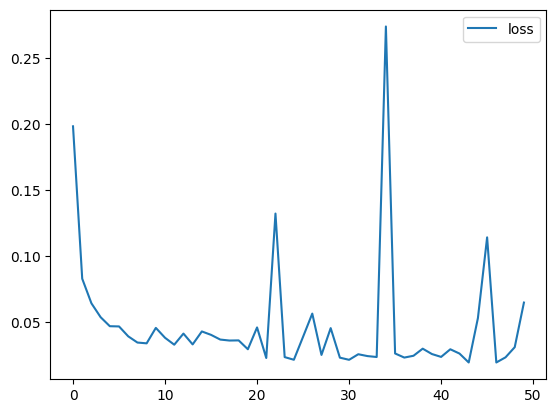

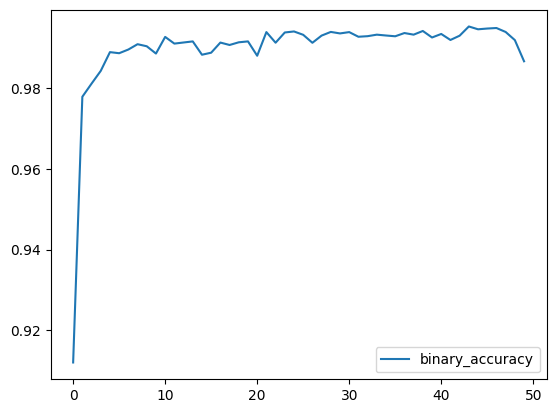

In [42]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True
)

neuralNetModel.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = neuralNetModel.fit(
    X_train, y_train,
    epochs=50,
    batch_size = 256,
    callbacks=[early_stopping]
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()
history_frame.loc[:, ['binary_accuracy']].plot();

In [43]:
predictions=(neuralNetModel.predict(X_test) > 0.5).astype("int32")


7143/7143 [==============================] - 6s 881us/step


In [44]:
print(accuracy_score(y_test, predictions))

0.9926060743942668


<Axes: >

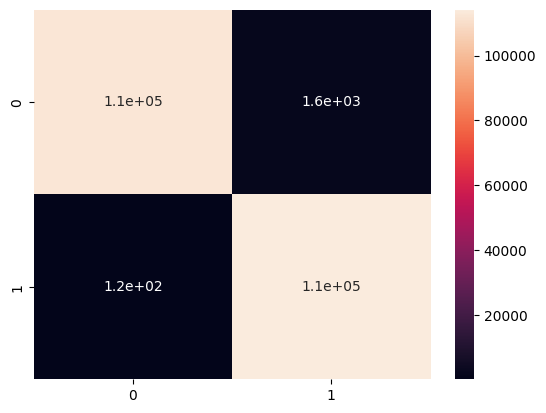

In [45]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)